In [9]:
!pip install bs4 --quiet

In [107]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from itertools import combinations
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('leavingny.csv'); df.head(2)

,URL,Words,Platform,Query,Title,Description,Language,Published Date,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,https://medium.com/new-york-diary/the-long-hel...,967,Medium,goodbye new york,The Long Hello - New York Diary - Mediummedium...,"Not long ago, I might have written my own 'Goo...",en,2013-12-06,NaN,NaN,NaN,NaN
1,https://medium.com/@EdwardCharles/it-s-not-you...,3036,Medium,goodbye new york,"It's Not You, It's Me. - Ned Dymoke - Mediumme...",They say every writer gets a “Goodbye New York...,en,2015-06-01,NaN,NaN,NaN,NaN


In [45]:
def scrape_story(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    sections = soup.find_all('section')
    story_paragraphs = []
    section_titles = []
    
    for section in sections:
        paragraphs = section.find_all('p')
        for paragraph in paragraphs:
            story_paragraphs.append(paragraph.text)

        subs = section.find_all('h1')
        for sub in subs:
            section_titles.append(sub.text)

    number_sections = len(section_titles)
    number_paragraphs = len(story_paragraphs)
    
    return story_paragraphs



In [73]:
data = {}

for i in range(df.loc[:,'URL'].size):
    try:
        story_txt = scrape_story(df.loc[:,'URL'][i])
        data[i] = story_txt
    except:
        break

In [92]:
textDf = pd.DataFrame.from_dict(data.items()).drop([0], axis=1)
textDf = textDf.rename(columns={1:'text'})

In [95]:
textDf.text = textDf['text'].apply(lambda x: ','.join(map(str, x)))

In [96]:
textDf.head()

,text
0,In Joan Didion’s brilliant and seminal 1967 es...
1,"Ned Dymoke,Jun 1, 2015·13 min read,They say ev..."
2,"Joe Gonzalez,Jun 24, 2015·7 min read,This isn’..."
3,"Gabe Durazo,Jul 31, 2015·2 min read,A few days..."
4,"Pattharin O.,Sep 9, 2015·1 min read,Goodbye Ne..."


In [241]:
def cleanText(text, stemmer=True, bigrams=False):
    sw = set(stopwords.words('english'))
    sw.update(['new','New','york','York', 'cities'])
    
    text = text.apply(gensim.utils.simple_preprocess, deacc=True, min_len=2)
    text = text.apply(lambda s: [w for w in s if w not in sw]) 
    if stemmer: text = text.apply(lambda s: [SnowballStemmer("english", ignore_stopwords=True).stem(w) for w in s])
    if bigrams: text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)

    return text
    

In [242]:
cleanTxt = cleanText(textDf.text).apply(lambda x: ' '.join(map(str, x)))

In [243]:
cleanTxt

0     joan didion brilliant semin essay goodby vogu ...
1     ned dymok jun min read say everi writer get go...
2     joe gonzalez jun min read anoth stori citi bet...
3     gabe durazo jul min read day ago pack everyth ...
4     pattharin sep min read goodby pack poem come f...
                            ...                        
74    austin samsel aug min read whoa wtf found ask ...
75    global nomad group sep min read rachel kornhau...
76    lot dec min read download iphon game call rest...
77    ezinn ukoha dec min read year without began in...
78    alexand fine jan min read food person inspir v...
Name: text, Length: 79, dtype: object

In [244]:
txt = []

for w in cleanTxt:
    if w != ',':
        txt.append(w)

In [247]:
from nltk.probability import FreqDist

freq = FreqDist()

for i in range(len(txt)):
    for w in nltk.tokenize.word_tokenize(txt[i]):
        if w != 'citi':
            freq[w] += 1

freq

FreqDist({'time': 354, 'year': 309, 'like': 274, 'one': 270, 'climat': 246, 'day': 217, 'would': 199, 'work': 196, 'back': 189, 'live': 185, ...})

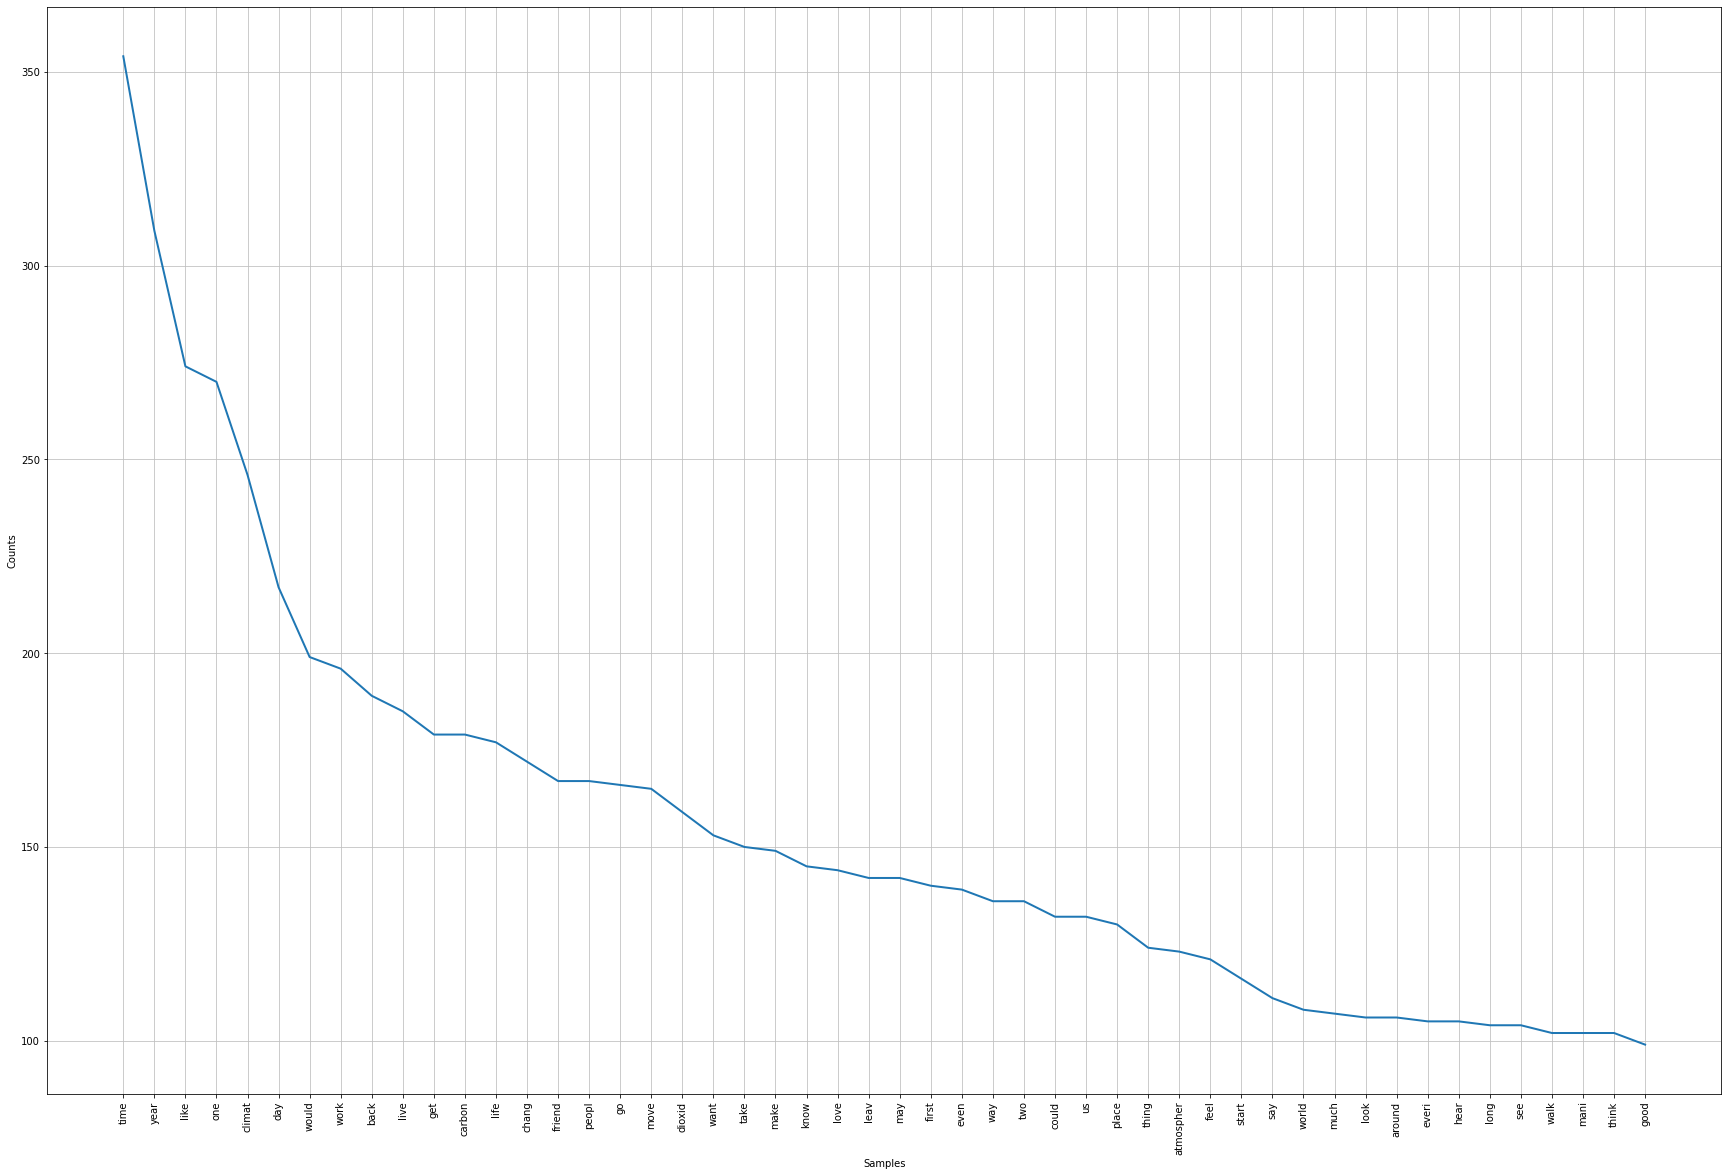

In [248]:
plt.figure(figsize=(30, 20))

freq.plot(50, cumulative=False)
plt.show()

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

tfidf = TfidfVectorizer()

processed_tfidf = tfidf.fit_transform(pd.DataFrame(cleanTxt).apply(lambda x: ', '.join(x)))
terms = tfidf.get_feature_names() 

In [226]:
print(len(terms))


48529


In [249]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

score = processed_tfidf.sum(axis=0)

tfidf_sorted = sorted({str(t): float(score[0,c]) for c,t in enumerate(terms)}.items(), 
                       key=operator.itemgetter(1),
                       reverse=True)

In [250]:
tfidf_sorted

[('time', 0.21990097385566607),
 ('citi', 0.20685600083032996),
 ('year', 0.1919474602299458),
 ('like', 0.17020583852105228),
 ('one', 0.16772108175432157),
 ('climat', 0.15281254115393744),
 ('day', 0.13479805459513994),
 ('would', 0.12361664914485183),
 ('work', 0.12175308156980381),
 ('back', 0.11740475722802511),
 ('live', 0.11492000046129441),
 ('carbon', 0.11119286531119839),
 ('get', 0.11119286531119839),
 ('life', 0.10995048692783303),
 ('chang', 0.10684454096941967),
 ('friend', 0.10373859501100631),
 ('peopl', 0.10373859501100631),
 ('go', 0.10311740581932365),
 ('move', 0.10249621662764097),
 ('dioxid', 0.09876908147754493),
 ('carbon_dioxid', 0.09814789228586226),
 ('want', 0.09504194632744889),
 ('take', 0.09317837875240088),
 ('make', 0.0925571895607182),
 ('know', 0.09007243279398752),
 ('love', 0.08945124360230484),
 ('leav', 0.0882088652189395),
 ('may', 0.0882088652189395),
 ('first', 0.08696648683557415),
 ('even', 0.08634529764389148),
 ('two', 0.08448173006884346)

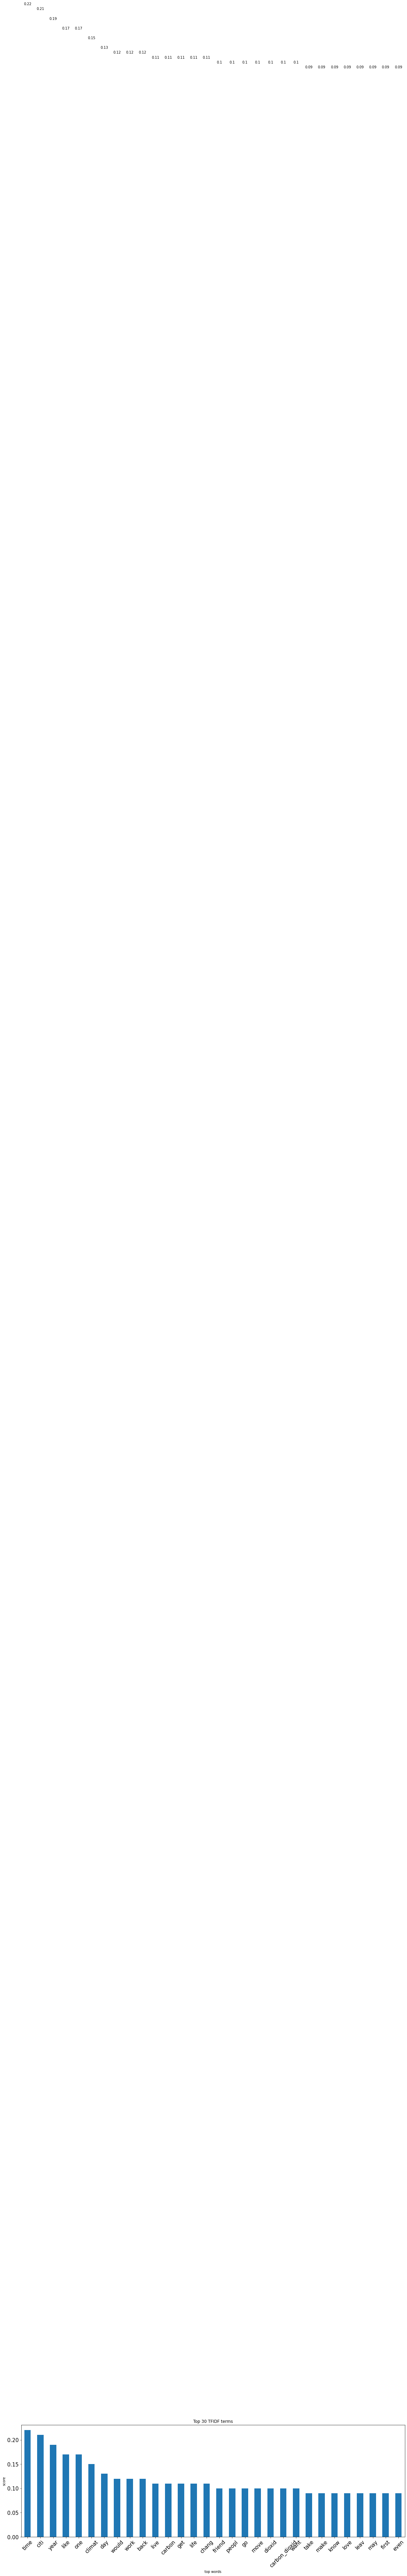

In [251]:
# visualize top terms

import pandas as pd

x_labels = [val[0] for val in tfidf_sorted[:30]]
y_labels = [round(val[1],2) for val in tfidf_sorted[:30]]

plt.figure(figsize=(20, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)
plt.title('Top 30 TFIDF terms')
plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('top words')
plt.ylabel('score')

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')